# Lotka-Volterra Three Ways

We will give three examples of deriving the Lotka-Volterra equations $$ \dot r(t) = \alpha r(t) - \beta r(t)f(t), \dot f(t) = \gamma f(t) r(t) - \delta f(t)$$ as a composition of primitive systems. First, we will show it as the composition of resource sharers where the undirected composition pattern is an undirected wiring diagram. Second, we will show it as the composition of machines where the directed composition pattern is a wiring diagram. Lastly, we will show it as the composition of machines where the directed composition pattern is an open circular port graph (open CPG).

Although these examples are quite small and you can easily work them out by hand,  this approach is based on the solid mathematical theory of operad algebras that allows you to scale to larger and more complex problems.

## Undirected composition
### Undirected wiring diagrams

A standard Lotka-Volterra predator-prey model is the composition of three resource sharers:

1. a model of rabbit growth: this resource sharer has dynamics $\dot r(t) = \alpha r(t)$ and one port which exposes the rabbit population.
2. a model of rabbit/fox predation: this resource sharer has dynamics $$\dot r(t) = -\beta r(t) f(t), \dot f(t) = \gamma r(t)f(t)$$ and two ports which expose the rabbit and fox populations respectively
3. a model of fox population decline: this resource sharer has dynamics $\dot f(t) = -\delta f(t)$ and one port which exposes the fox population.

However, there are not two independent rabbit populations --- one that grows and one that gets eaten by foxes. Likewise, there are not two independent fox populations --- one that declines and one that feasts on rabbits. To capture these interactions between the trio of resource sharers, we compose them by identifying the exposed rabbit populations and identifying the exposed fox populations.

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


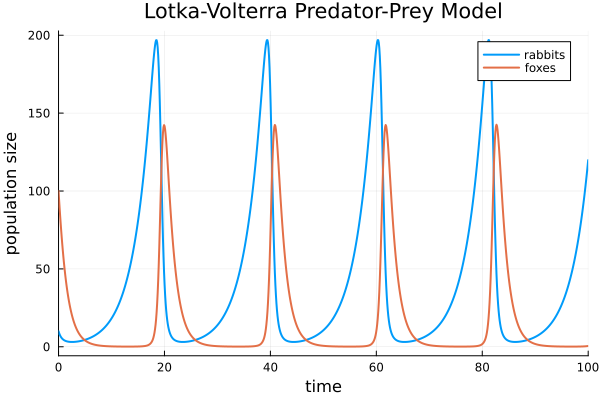

In [1]:
using AlgebraicDynamics
using Catlab.WiringDiagrams, Catlab.Programs

using LabelledArrays
using OrdinaryDiffEq, Plots, Plots.PlotMeasures

const UWD = UndirectedWiringDiagram

# Define the primitive systems
dotr(u,p,t) = p.α*u
dotrf(u,p,t) = [-p.β*u[1]*u[2], p.γ*u[1]*u[2]]
dotf(u,p,t) = -p.δ*u

rabbit_growth = ContinuousResourceSharer{Float64}(1, dotr)
rabbitfox_predation = ContinuousResourceSharer{Float64}(2, dotrf)
fox_decline = ContinuousResourceSharer{Float64}(1, dotf)

# Define the composition pattern
rf = @relation (rabbits,foxes) begin
    growth(rabbits)
    predation(rabbits,foxes)
    decline(foxes)
end

# Compose
rabbitfox_system = oapply(rf, [rabbit_growth, rabbitfox_predation, fox_decline])

# Solve and plot
u0 = [10.0, 100.0]
params = LVector(α=.3, β=0.015, γ=0.015, δ=0.7)
tspan = (0.0, 100.0)

prob = ODEProblem(rabbitfox_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, rabbitfox_system,
    lw=2, title = "Lotka-Volterra Predator-Prey Model",
    xlabel = "time", ylabel = "population size"
)

## Directed composition
A standard Lotka-Volterra predator-prey model is the composition of two machines:

1. Evolution of a rabbit population: this machine has one input which represents a population of predators, $h(t)$, that hunt rabbits. This machine has one output which emits the rabbit population $r(t)$. The dynamics of this machine is the driven ODE $\dot r(t) = \alpha r(t) - \beta r(t) h(t).$

2. Evoluation of a fox population: this machine has one input which represents a population of prey, $e(t)$, that are eaten by foxes. This machine has one output which emits the fox population $f(t)$. The dynamics of this machine is the driven ODE $\dot f(t) =\gamma f(t)e(t) - \delta f(t).$

### Wiring diagrams
Since foxes hunt rabbit, these machines compose by setting the fox population to be the input for rabbit evolution. Likewise, we set the rabbit population to be the input for fox evolution. We first implement this setting of inputs using a wiring diagram as our composition pattern.

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


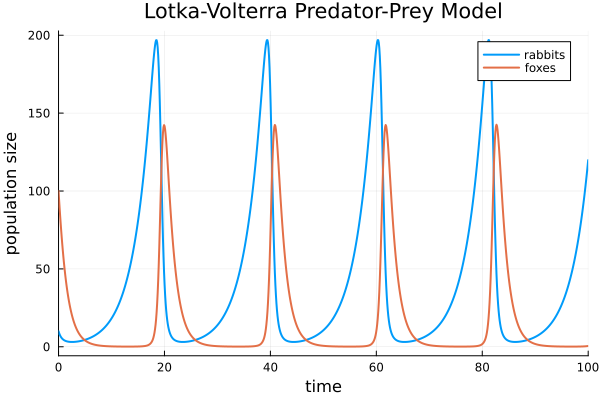

In [2]:
using AlgebraicDynamics.DWDDynam

# Define the primitive systems
dotr(u, x, p, t) = [p.α*u[1] - p.β*u[1]*x[1]]
dotf(u, x, p, t) = [p.γ*u[1]*x[1] - p.δ*u[1]]

rabbit = ContinuousMachine{Float64}(1,1,1, dotr, (u, p, t) -> u)
fox    = ContinuousMachine{Float64}(1,1,1, dotf, (u, p, t) -> u)

# Define the composition pattern
rabbitfox_pattern = WiringDiagram([], [:rabbits, :foxes])
rabbit_box = add_box!(rabbitfox_pattern, Box(:rabbit, [:pop], [:pop]))
fox_box = add_box!(rabbitfox_pattern, Box(:fox, [:pop], [:pop]))

add_wires!(rabbitfox_pattern, Pair[
    (rabbit_box, 1) => (fox_box, 1),
    (fox_box, 1)    => (rabbit_box, 1),
    (rabbit_box, 1) => (output_id(rabbitfox_pattern), 1),
    (fox_box, 1)    => (output_id(rabbitfox_pattern), 2)
])

# Compose
rabbitfox_system = oapply(rabbitfox_pattern, [rabbit, fox])

# Solve and plot
u0 = [10.0, 100.0]
params = LVector(α=.3, β=0.015, γ=0.015, δ=0.7)
tspan = (0.0, 100.0)

prob = ODEProblem(rabbitfox_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, rabbitfox_system, params,
    lw=2, title = "Lotka-Volterra Predator-Prey Model",
    xlabel = "time", ylabel = "population size"
)

### Open CPG
We next implement the setting of inputs using an open CPG as our composition pattern. We will use a barbell CPG. A barbell has two boxes connected by $n$ wires. In this instance we will set $n$ to $1$ since each machine receives and emits exactly one piece of information.

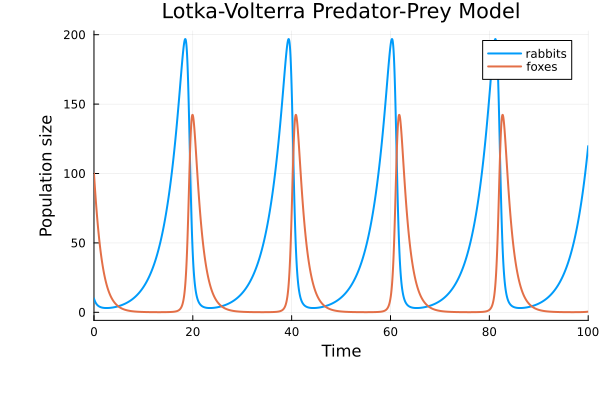

In [3]:
using AlgebraicDynamics.CPortGraphDynam
using AlgebraicDynamics.CPortGraphDynam: barbell

# Define the composition pattern
rabbitfox_pattern = barbell(1)

# Compose
rabbitfox_system = oapply(rabbitfox_pattern, [rabbit, fox])

# Solve and plot
u0 = [10.0, 100.0]
params = LVector(α=.3, β=0.015, γ=0.015, δ=0.7)
tspan = (0.0, 100.0)

prob = ODEProblem(rabbitfox_system, u0, tspan, params)
sol = solve(prob, FRK65(0))

plot(sol, lw=2, bottom_margin=10mm, left_margin=10mm, title = "Lotka-Volterra Predator-Prey Model", label=["rabbits" "foxes"])
xlabel!("Time")
ylabel!("Population size")